## 계수를 효과적으로 분석하는 받법 정리하기

In [2]:
import numpy as np
import pandas as pd

In [3]:
# 계수 불러오기
setting_path = 'long_term_forecast_iTransformer_Exchange_96_96_Mod-iTransformer_data-exchange_rate.csv_(96to96)_0(1728896616)'

# numpy 오브젝트 불러오기
np_pred = np.load(f'./results/{setting_path}/pred.npy')
np_true = np.load(f'./results/{setting_path}/true.npy')
np_ensemble = np.load(f'./results/{setting_path}/pred_ensemble.npy')
np_coef_col = np.load(f"./results/{setting_path}/coef_col.npy")
np_coef_metric = np.load(f"./results/{setting_path}/coef_metric.npy", allow_pickle=True)


In [58]:
np_coef_metric

array([{'cnt': 0, 'a': 0.95, 'b': 0.04, 'MSE': 0.091578834, 'MAE': 0.21359576, 'SMAE': -0.06910763},
       {'cnt': 1, 'a': 0.92372143, 'b': 0.036376823, 'MSE': 0.09057413, 'MAE': 0.21238431, 'SMAE': -0.06737617},
       {'cnt': 2, 'a': 0.8677582, 'b': 0.033987157, 'MSE': 0.089211315, 'MAE': 0.21070072, 'SMAE': -0.063710794},
       {'cnt': 3, 'a': 0.74732393, 'b': 0.032867666, 'MSE': 0.089705296, 'MAE': 0.2110862, 'SMAE': -0.055839285},
       {'cnt': 4, 'a': 0.65112424, 'b': 0.032531135, 'MSE': 0.093451194, 'MAE': 0.21525234, 'SMAE': -0.049553987},
       {'cnt': 5, 'a': 0.61255646, 'b': 0.032950215, 'MSE': 0.09575844, 'MAE': 0.21775702, 'SMAE': -0.047036406},
       {'cnt': 6, 'a': 0.612474, 'b': 0.032957166, 'MSE': 0.095763505, 'MAE': 0.21776249, 'SMAE': -0.047031075},
       {'cnt': 7, 'a': 0.6002659, 'b': 0.033556703, 'MSE': 0.09656432, 'MAE': 0.21862449, 'SMAE': -0.04623608},
       {'cnt': 8, 'a': 0.6152294, 'b': 0.034415904, 'MSE': 0.09549682, 'MAE': 0.21748014, 'SMAE': -0.047

In [1]:
from utils.metrics import *
from utils.tools import get_Xval, res_lin_reg, get_res_lin, zero_model, sigmoid_inverse
from data_provider.data_factory import data_provider
from data_provider.data_loader import Dataset_Custom

In [15]:
import argparse
from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
from exp.exp_imputation import Exp_Imputation
from exp.exp_short_term_forecasting import Exp_Short_Term_Forecast
from exp.exp_long_term_forecasting_partial import Exp_Long_Term_Forecast_Partial
from exp.exp_anomaly_detection import Exp_Anomaly_Detection
from exp.exp_classification import Exp_Classification
from utils.print_args import print_args
import random
from utils.tools import EarlyStopping
import time

In [6]:
# 모델 훈련셋 결과 확인하기
from torch.utils.data import DataLoader

# 파서 불러오기
from commons.parser_write import *

In [7]:
script_args = """--task_name long_term_forecast \
  --is_training 1 \
  --root_path ./dataset/exchange_rate/ \
  --data_path exchange_rate.csv \
  --model_id iTransformer_Exchange_96_96 \
  --model DLinear \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 8 \
  --dec_in 8 \
  --c_out 8 \
  --batch_size 8 \
  --d_model 64\
  --d_ff 128\
  --des 'Exp' \
  --itr 1"""

In [8]:
args = parser.parse_args(script_args.split())
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [9]:
dataset_input = Dataset_Custom(args, args.root_path,
                                    flag='train', size=(args.seq_len, args.label_len, args.pred_len),
                                    features='M', data_path = args.data_path,
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=args.train_ratio, test_ratio=args.test_ratio)
dataset_input_val = Dataset_Custom(args, args.root_path,
                                    flag='val', size=(args.seq_len, args.label_len, args.pred_len),
                                    features='M', data_path = args.data_path,
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=args.train_ratio, test_ratio=args.test_ratio)
dataset_input_test = Dataset_Custom(args, args.root_path,
                                    flag='test', size=(args.seq_len, args.label_len, args.pred_len),
                                    features='M', data_path = args.data_path,
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=args.train_ratio, test_ratio=args.test_ratio)


In [10]:
dataset_input_loader = DataLoader(
        dataset_input,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.num_workers,
        drop_last=False)
dataset_input_val_loader = DataLoader(
        dataset_input_val,
        batch_size=1, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
        shuffle=False,
        num_workers=args.num_workers,
        drop_last=False)
dataset_input_test_loader = DataLoader(
        dataset_input_test,
        batch_size=1, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
        shuffle=False,
        num_workers=args.num_workers,
        drop_last=False)

In [11]:
X_old, X_new, X_concat = get_Xval(args.seq_len, args.pred_len)

In [76]:
idx = 0 # 순서
col_count = 10 # 한 에포크당 수집 데이터 수
num_epochs = 10 # 에포크 ㅅ횟수
use_gpu = 0 # 사용 GPU 번호 - 오류 잡기 위해 
# q1, q2 = "lin96", "lin24" # 앙상블 모델 텍스트
q1, q2 = "lin24", "lin96" # 앙상블 모델 텍스트
q1, q2 = "lin96", "lin48" # 앙상블 모델 텍스트
a_init , b_init = sigmoid_inverse(0.999), sigmoid_inverse(0.0005)  # 초기값(sigmoid로변환할  것 감안)  
lr = 0.005 #SGD 사용시에는 lr값을 충분히 키워서 쓸 것. Adam일 때는 0.01 정도가 적합
lr = 0.02
c_init = 0.0001

In [71]:
a_init, b_init

(6.906754778648552, -7.6004023345004)

In [77]:
# Combination 모델 제작, 2단계/3단계 대응
class CombinedModel(nn.Module):
    # 모델 정의 - 
    def __init__(self, res_A, res_B, res_C):
        super(CombinedModel, self).__init__()
        self.res_A = res_A  # iTransformer train_result
        self.res_B = res_B  # lin_reg_96 train_result
        self.res_C = res_C
        self.a = nn.Parameter(torch.ones(1, device=device)*a_init, requires_grad=True)
        self.b = nn.Parameter(torch.ones(1, device=device)*b_init, requires_grad=True)

        if res_C is not None:
            self.c = nn.Parameter(torch.ones(1, device=device)*(1-a_init -b_init), requires_grad=True)
        else:
            self.c = nn.Parameter(torch.ones(1, device=device)*0.0, requires_grad=True)

        # self.c = nn.Parameter(torch.ones(1, device=device)*0.0, requires_grad=True)
        # self.d = nn.Parameter(torch.zeros(1, device=device), requires_grad=True)
        self.a_sigmoid = torch.sigmoid(self.a)
        self.b_sigmoid = torch.sigmoid(self.b)
    
    def set_a(self, val):
        # nn.Parameter를 다시 생성하지 않고 값을 설정
        with torch.no_grad():
            self.a.copy_(torch.tensor([val], device=device))

    def set_b(self, val):
        # nn.Parameter를 다시 생성하지 않고 값을 설정
        with torch.no_grad():
            self.b.copy_(torch.tensor([val], device=device))
            
    def forward(self, x):
        output_A = self.res_A(x)
        output_B = self.res_B(x)
        
        # Apply sigmoid to ensure non-negative coefficients in range (0, 1)
        a_sigmoid = torch.sigmoid(self.a)
        b_sigmoid = torch.sigmoid(self.b)
        
        # Ensure the sum constraint by defining c as the remainder
        c_sigmoid = torch.clamp(1 - a_sigmoid - b_sigmoid, min=0, max=1)
    
        # Compute the combined output with updated a, b, c
        # print(output_A.shape, output_B.shape)

        
        combined_output = a_sigmoid * output_A + b_sigmoid * output_B
        
        self.a_sigmoid = a_sigmoid
        self.b_sigmoid = b_sigmoid
        
    
        if self.res_C is not None:
            output_C = self.res_C(x)
            combined_output += c_sigmoid * output_C
        
        # Compute the combined output with updated a, b, c
        # combined_output = a_sigmoid * output_A + b_sigmoid * output_B + c_sigmoid * (self.res_C(x) if self.res_C else 0)
            
    
        return combined_output
    
    def get_result(self):
        a, b = self.a_sigmoid.detach().cpu().numpy()[0], self.b_sigmoid.detach().cpu().numpy()[0]
        return a,b
        
    
# model_output_function

def res_iTransformer(batch_x): # S 
    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)
    return exp_model.model(batch_x, None, torch.zeros(B, len(X_new), N), None).permute(0, 2, 1) 


QMAP_FN = {
  "none": None,
  "lin12" : get_res_lin(12, args.pred_len),
  "lin24" : get_res_lin(24, args.pred_len),
  "lin48" : get_res_lin(48, args.pred_len),
  "lin96" : get_res_lin(96, args.pred_len),
  "lin" : get_res_lin(96, args.pred_len),
}

     


In [18]:

args.gpu = use_gpu

# 모델 호출 - Exp_Long_Term_Forecast - exchange_96_96
exp_model = Exp_Long_Term_Forecast(args)
exp_model._build_model()
device = torch.device(f"cuda:{use_gpu}")
exp_model.model.device = device

Use GPU: cuda:0


In [72]:
# 우선 train_set의 data_exchange를 바탕으로 측정값 참값 가져기
# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_te_tr = [] # 예측값
trues_te_tr = [] # 참값
preds_te_lin = [] # 96_lin
preds_te_lin_48 = [] # 48_lin
preds_te_lin_24 = [] # 24_lin
preds_te_lin_12 = [] # 24_lin

start_time = time.time() # 시작타
print(f"iteration start, time : {time.localtime()}")

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_input_loader):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)

    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)

    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(device)
    # encoder - decoder

    # use_amp도 사용하지 않음, 
    outputs = exp_model.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    
    # 각 배치와 변수에 대해 선형 회귀 해를 계산
    lin_result = res_lin_reg(batch_x, 96, args.pred_len).to(device)

    lin_result_24 = res_lin_reg(batch_x, 24, args.pred_len).to(device)
    
    # 48 테스트
    lin_result_48 = res_lin_reg(batch_x, 48, args.pred_len).to(device)
    
    # 12 테스트
    lin_result_12 = res_lin_reg(batch_x, 12, args.pred_len).to(device)
    
    outputs = outputs[:, -args.pred_len:, :]
    batch_y = batch_y[:, -args.pred_len:, :].to(device)
    outputs = outputs.detach().cpu().numpy()
    batch_y = batch_y.detach().cpu().numpy()

    pred = outputs
    true = batch_y

    preds_te_tr.append(pred)
    trues_te_tr.append(true)
    preds_te_lin.append(lin_result)
    preds_te_lin_24.append(lin_result_24)
    preds_te_lin_48.append(lin_result_48)
    preds_te_lin_12.append(lin_result_12)

    if (i+1)%100==0:
        print(f"step {i+1} completed")

    
preds_te_tr = np.concatenate(preds_te_tr, axis=0)
trues_te_tr = np.concatenate(trues_te_tr, axis=0)
preds_te_lin = np.transpose(torch.concat(preds_te_lin, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin_24 = np.transpose(torch.concat(preds_te_lin_24, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin_48 = np.transpose(torch.concat(preds_te_lin_48, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin_12 = np.transpose(torch.concat(preds_te_lin_12, axis=0).detach().cpu().numpy(), (0,2,1))
input_len = i + 1

# operation 끝
data_col_time = time.time()
print(f"경과 시간: {data_col_time-start_time}")

iteration start, time : time.struct_time(tm_year=2024, tm_mon=10, tm_mday=23, tm_hour=20, tm_min=36, tm_sec=12, tm_wday=2, tm_yday=297, tm_isdst=0)
step 100 completed
step 200 completed
step 300 completed
step 400 completed
step 500 completed
step 600 completed
경과 시간: 12.50006890296936


In [79]:
# 초기 모델 실험
combine_model_test = CombinedModel(res_iTransformer, QMAP_FN[q1], QMAP_FN[q2])
combine_model_test.eval()

CombinedModel()

In [80]:
# 초기모델 훈련
vali(dataset_input_test, dataset_input_test_loader, criterion)

0.14430478748337544

In [81]:
combine_model_test.get_result()

(0.999, 0.0005)

In [82]:
combine_model_test.eval()

CombinedModel()

In [ ]:
# outputs와 비교 

In [102]:
total_loss_map = []
outputs_test = []
origins_test = []
with torch.no_grad():
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_input_test_loader):
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)
        targets = batch_y[:, -args.pred_len:, :].to(device)
        outputs = combine_model_test(batch_x).permute(0,2,1)
        origins = res_iTransformer(batch_x)
        outputs_test.append(outputs.detach().cpu().numpy())
        origins_test.append(origins.detach().cpu().numpy())
        loss = criterion(outputs, targets)
        total_loss_map.append(loss)

outputs_test = np.concatenate(outputs_test, axis=0)
origins_test = np.concatenate(origins_test, axis=0)
total_loss_map = [v.item() for v in total_loss_map]
total_loss_val = np.average(total_loss_map)

In [103]:
outputs_test.shape, np_pred.shape, origins_test.shape

((1422, 96, 8), (1422, 96, 8), (1422, 8, 96))

In [104]:
MSE(outputs_test, np_pred), MSE(np.transpose(origins_test, (0,2,1)), outputs_test), MSE(np.transpose(origins_test, (0,2,1)), np_pred)

(0.06093859, 2.2102746e-07, 0.061114024)

In [94]:
total_loss_val

0.14430478748337544

In [73]:
# 모델 실험
combine_model_test = CombinedModel(res_iTransformer, QMAP_FN[q1], QMAP_FN[q2])
# combine_model_test.set_a(0.95)
# combine_model_test.set_b(0.025)

# combine_model_test training
combine_model_test.train()
torch.nn.utils.clip_grad_norm_(combine_model_test.parameters(), max_norm=1) # gradient clipping - 크기 제한

criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(combine_model_test.parameters(), lr=lr, weight_decay=1e-4)
# optimizer = torch.optim.Adam([combine_model_test.a,combine_model_test.b], lr=lr, weight_decay=1e-5)
optimizer = torch.optim.SGD([combine_model_test.a,combine_model_test.b], lr=lr, momentum=0.9)

# 검증 데이터셋 결과 확인
def vali(vali_data, vali_loader, criterion):
    total_loss = []
    combine_model_test.eval()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            targets = batch_y[:, -args.pred_len:, :].to(device)
            outputs = combine_model_test(batch_x).permute(0,2,1)
            loss = criterion(outputs, targets)
            total_loss.append(loss)
        
        
    total_loss = [v.item() for v in total_loss]
    total_loss = np.average(total_loss)
    combine_model_test.train()
    return total_loss
    
# 모델 훈련

loss_points = [] # (a, b)
# input_len = int(np.ceil(len(dataset_input) / args.batch_size) )
input_len_div = int(np.ceil(input_len / (col_count - 1)))

print("INPUT_LEN", input_len, input_len_div)

INPUT_LEN 640 128


In [75]:
# early_stopping = EarlyStopping(patience=2, verbose=True)
for epoch in range(num_epochs):
    cnt = 0
    train_loss = []
    # exp_model.train()

    
    path = os.path.join(args.checkpoints, setting_path)
    if not os.path.exists(path):
        os.makedirs(path)
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_input_loader):
        cnt += 1
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)
        targets = batch_y[:, -args.pred_len:, :].to(device)
        optimizer.zero_grad()
        outputs = combine_model_test(batch_x).permute(0,2,1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss.append(loss)
        if (cnt+1) % 50 == 0:
            print(f"{cnt+1}th batch done, loss {loss}")
        if i == input_len -1 or i % input_len_div == 0:
            a, b = combine_model_test.get_result()
            print(f"STEP {i}", combine_model_test.get_result(), f"loss {loss}" )
            loss_points.append((a,b))
            train_loss_res = vali(dataset_input, dataset_input_loader, criterion)
            vali_loss = vali(dataset_input_test, dataset_input_test_loader, criterion)
            print("train_loss, vali_loss:", train_loss_res, vali_loss)

    print("="*50)
    print(f"Epoch {epoch+1} DONE")
    print()
    train_loss = [v.item() for v in train_loss]
    train_loss = np.average(train_loss)
    vali_loss = vali(dataset_input_test, dataset_input_test_loader, criterion)
    # print("vali_loss:", vali_loss)
    # print()
    print(a,b)
    # early_stopping(vali_loss, combine_model_test, path)
    # if early_stopping.early_stop:
    #    print("Early stopping")
    #    break
    model_path = path + '/' + 'checkpoint_ensenble.pth'
    # torch.save(combine_model_test.state_dict(), model_path)
    # combine_model_test.load_state_dict(torch.load(model_path, map_location=device))

# 훈련 결과 도출
combine_model_test.eval()

# 계수 수집 끝
end_time = time.time()
print(f"Find Coefficients process done. Spent :{end_time - start_time}")


STEP 0 (0.999, 0.0005) loss 0.21561014652252197
train_loss, vali_loss: 0.2173987363348715 0.14430478768247676
50th batch done, loss 0.42367029190063477
100th batch done, loss 0.15072906017303467
STEP 128 (0.99899024, 0.0004993625) loss 0.23007416725158691
train_loss, vali_loss: 0.21739499670220538 0.1443023605484374
150th batch done, loss 0.09922479093074799
200th batch done, loss 0.17325910925865173
250th batch done, loss 0.3990445137023926
STEP 256 (0.9989806, 0.000498644) loss 0.121451735496521
train_loss, vali_loss: 0.21739133823430165 0.14429998687833925
300th batch done, loss 0.350226491689682
350th batch done, loss 0.13705287873744965
STEP 384 (0.99897015, 0.0004979579) loss 0.19153475761413574
train_loss, vali_loss: 0.21738739614374936 0.14429742800472659
400th batch done, loss 0.2859424948692322
450th batch done, loss 0.16855472326278687
500th batch done, loss 0.1541624665260315
STEP 512 (0.9989612, 0.000497429) loss 0.39113864302635193
train_loss, vali_loss: 0.217384067771490

In [ ]:
# 검증 데이터셋 결과 확인
def vali(vali_data, vali_loader, criterion):
    total_loss = []
    combine_model_test.eval()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            targets = batch_y[:, -args.pred_len:, :].to(device)
            outputs = combine_model_test(batch_x).permute(0,2,1)
            loss = criterion(outputs, targets)
            total_loss.append(loss)
        
        
    total_loss = [v.item() for v in total_loss]
    total_loss = np.average(total_loss)
    combine_model_test.train()
    return total_loss

In [26]:
# total_loss 데이터 이용해서 계산


array([[ 2.74921602, -0.67234377,  1.84301689,  2.78282589,  0.78109494,
         3.21969717,  2.79752751,  1.94913024],
       [ 2.75157278, -0.67234377,  1.84301689,  2.78282589,  0.78109494,
         3.21969717,  2.79202794,  1.94913024],
       [ 2.67890114, -0.68885139,  1.79601561,  2.72405395,  0.78052119,
         3.33957218,  2.75365673,  1.90736717],
       [ 2.74293132, -0.64674682,  1.83565664,  2.71577002,  0.7825102 ,
         3.35501063,  2.80486028,  1.95701066],
       [ 2.75363858, -0.68567042,  1.82922366,  2.69821688,  0.78744449,
         3.3214093 ,  2.81185156,  1.95569901],
       [ 2.69343935, -0.73200635,  1.74261999,  2.65717027,  0.78744449,
         3.36500021,  2.75399821,  1.88987495],
       [ 2.92216153, -0.61308106,  1.8986341 ,  2.84824602,  0.79065752,
         3.30052198,  2.91961445,  2.07429355],
       [ 2.9189125 , -0.60308458,  1.91351881,  2.86345555,  0.79073402,
         3.30597085,  2.93866526,  2.06349601],
       [ 2.92134685, -0.60308458

In [51]:
# np_pred, np_true와 dataset_test_loader 일치한 정도 확인

np_pred_1 = []
np_true_1 = []
np_before = []
np_pred_lin = []
np_pred_lin48 = []
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_input_test_loader):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)
    targets = batch_y[:, -args.pred_len:, :].to(device)
    outputs = combine_model_test(batch_x).permute(0,2,1)
    output_96 = res_lin_reg(targets, 96, 96)
    output_48 = res_lin_reg(targets, 48, 96)
    np_input_part = batch_x.detach().cpu().numpy()
    np_pred_part = outputs.detach().cpu().numpy()
    np_true_part = targets.detach().cpu().numpy()
    np_pred_lin_part = outputs.detach().cpu().numpy()
    np_pred_lin48_part = outputs.detach().cpu().numpy()
    np_before.append(np_input_part)
    np_pred_1.append(np_pred_part)
    np_true_1.append(np_true_part)
    np_pred_lin.append(np_pred_lin_part)
    np_pred_lin48.append(np_pred_lin48_part)

In [52]:
np_before = np.concatenate(np_before, axis=0)
np_pred_1 = np.concatenate(np_pred_1, axis=0)
np_true_1 = np.concatenate(np_true_1, axis=0)
np_pred_lin = np.concatenate(np_pred_lin, axis=0)
np_pred_lin48 = np.concatenate(np_pred_lin48, axis=0)

In [33]:
np_before.shape, np_pred_1.shape, np_true_1.shape, np_pred.shape, np_true.shape

((1422, 96, 8), (1422, 96, 8), (1422, 96, 8), (1422, 96, 8), (1422, 96, 8))

In [35]:
MSE(np_pred_1, np_pred), MSE(np_true_1, np_true), MSE(np_before[96:,:,:], np_true_1[:-96,:,:]), MSE(np_before[96:,:,:], np_true[:-96,:,:])

(0.027347272, 0.0, 0.0, 0.0)

In [50]:
MSE(np_pred_1, np_ensemble), MSE(np_pred, np_ensemble)

(0.020583704, 0.0021856672)

In [54]:
MSE(sigmoid(ax)*np_pred + sigmoid(bx)*np_pred_lin + (1-sigmoid(ax)-sigmoid(bx))*np_pred_lin48, np_true)

0.0873272

In [56]:
MSE(np_pred, np_true), MSE(np_pred_1, sigmoid(ax)*np_pred + sigmoid(bx)*np_pred_lin + (1-sigmoid(ax)-sigmoid(bx))*np_pred_lin48)

(0.09395402, 0.009696329)

In [62]:
ax, bx, cx = float(combine_model_test.a[0].detach().cpu().numpy()), float(combine_model_test.b[0].detach().cpu().numpy()), float(combine_model_test.c[0].detach().cpu().numpy())

In [63]:
ax, bx, cx

(0.38654932379722595, -2.9288296699523926, 1.2336148023605347)

In [64]:
sigmoid = lambda x: 1 / (1 + np.exp(-x)) # exp는 지수 함수를 의미함
sigmoid(ax), sigmoid(bx), sigmoid(cx)

(0.5954517439980606, 0.05074667179103758, 0.7744506229369102)

In [65]:
MSE(sigmoid(ax)*np_pred + sigmoid(bx)*np_pred_lin + sigmoid(cx)*np_pred_lin48, np_true)

0.76754034

In [ ]:
get_res_lin(

In [69]:
mse_o_vals = []
mse_n_vals = []
for t in np_coef_metric:
    a, b = t["a"], t["b"]
    mse_o, mae_o, smae_o = t["MSE"], t["MAE"], t["SMAE"]
    sval = a*np_pred + b* np_pred_lin + (1-a-b)*np_pred_lin48
    mse_n, mae_n, smae_n = MSE(sval, np_true), MAE(sval, np_true), SMAE(sval, np_true)
    print(a,b,1-a-b)
    print("ORIGIN")
    print(mse_o, mae_o, smae_o)
    print("NEWVAL")
    print(mse_n, mae_n, smae_n)
    print("-"*50)
    mse_o_vals.append(mse_o)
    mse_n_vals.append(mse_n)

print(min(mse_o_vals), mse_o_vals.index(min(mse_o_vals)))
print(min(mse_n_vals), mse_n_vals.index(min(mse_n_vals)))

0.95 0.04 0.010000012814998627
ORIGIN
0.091578834 0.21359576 -0.06910763
NEWVAL
0.09265019 0.2147325 -0.07185938
--------------------------------------------------
0.92372143 0.036376823 0.039901744574308395
ORIGIN
0.09057413 0.21238431 -0.06737617
NEWVAL
0.09201975 0.21399082 -0.07167538
--------------------------------------------------
0.8677582 0.033987157 0.09825462847948074
ORIGIN
0.089211315 0.21070072 -0.063710794
NEWVAL
0.09080299 0.21257876 -0.0712835
--------------------------------------------------
0.74732393 0.032867666 0.2198084034025669
ORIGIN
0.089705296 0.2110862 -0.055839285
NEWVAL
0.08876556 0.21033609 -0.07044013
--------------------------------------------------
0.65112424 0.032531135 0.31634462624788284
ORIGIN
0.093451194 0.21525234 -0.049553987
NEWVAL
0.08770802 0.20936017 -0.06976651
--------------------------------------------------
0.61255646 0.032950215 0.35449332743883133
ORIGIN
0.09575844 0.21775702 -0.047036406
NEWVAL
0.08742615 0.20917615 -0.06949645
---

In [ ]:
# 계수 그래프 그려기기

In [105]:
setting_path = "long_term_forecast_iTransformer_Exchange_96_96_Mod-iTransformer_data-exchange_rate.csv_(96to96)_0(1729736010)"
np_coef_metric = np.load(f"./results/{setting_path}/coef_metric.npy", allow_pickle=True)

In [106]:
np_coef_metric

array([{'cnt': 0, 'a': 0.95, 'b': 0.04, 'MSE': 0.09166475, 'MAE': 0.21361335, 'SMAE': -0.068984486},
       {'cnt': 1, 'a': 0.9233256, 'b': 0.039470036, 'MSE': 0.090557046, 'MAE': 0.21236627, 'SMAE': -0.06735374},
       {'cnt': 2, 'a': 0.9036726, 'b': 0.027427327, 'MSE': 0.08983227, 'MAE': 0.21159573, 'SMAE': -0.06620008},
       {'cnt': 3, 'a': 0.9051353, 'b': 0.023452755, 'MSE': 0.089882866, 'MAE': 0.21166594, 'SMAE': -0.06630592},
       {'cnt': 4, 'a': 0.9546357, 'b': 0.043301947, 'MSE': 0.09189787, 'MAE': 0.2138699, 'SMAE': -0.0692547},
       {'cnt': 5, 'a': 0.9437598, 'b': 0.03666357, 'MSE': 0.09137247, 'MAE': 0.21329112, 'SMAE': -0.06861617},
       {'cnt': 6, 'a': 0.9503691, 'b': 0.044972863, 'MSE': 0.09171727, 'MAE': 0.21366179, 'SMAE': -0.06898668},
       {'cnt': 7, 'a': 0.9356197, 'b': 0.034023277, 'MSE': 0.09102029, 'MAE': 0.21290173, 'SMAE': -0.0681287},
       {'cnt': 8, 'a': 0.911052, 'b': 0.029825455, 'MSE': 0.09008272, 'MAE': 0.21186559, 'SMAE': -0.06664199},
      

In [107]:
%matplotlib inline

In [109]:
import matplotlib.pyplot as plt

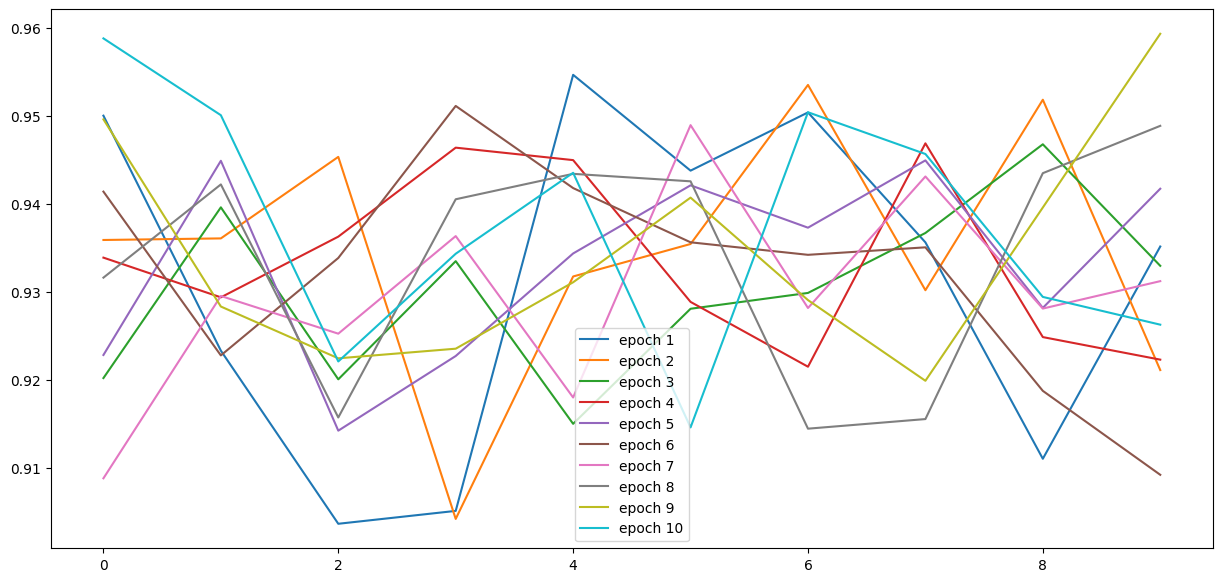

In [161]:
# 10개 단위로 했으므로 그래프 분석
plt.figure(figsize=(15,7))
a_map, b_map, c_map = [], [], []
ag_map, bg_map = [], []
for idx, tup in enumerate(np_coef_metric):
    a, b = tup["a"], tup["b"]
    q, r = idx//10, idx % 10 # 10으로 나눌 때 몫/나머지
    a_map.append(a)
    b_map.append(b)
    c_map.append(1-a-b)
    if r ==0:
        ag_map_part, bg_map_part = [], []
    ag_map_part.append(a)
    bg_map_part.append(b)
    if r ==9:
        ag_map.append(ag_map_part)
        bg_map.append(bg_map_part)
    
#plt.plot(range(100), a_map, label="a-val")
#plt.plot(range(100), b_map, label="b-val")
#plt.plot(range(100), c_map, label="c-val")
for idx1, val in enumerate(ag_map):
    plt.plot(range(10), ag_map[idx1], label=f"epoch {idx1+1}")
plt.legend()
plt.show()
    

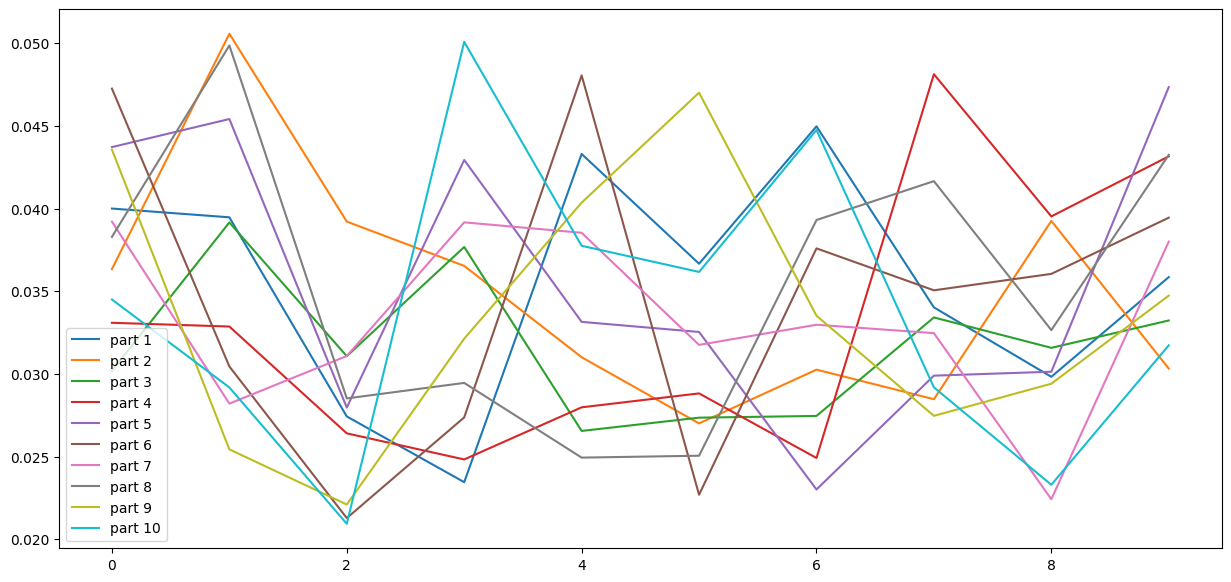

In [119]:
plt.figure(figsize=(15,7))
for idx1, val in enumerate(ag_map):
    plt.plot(range(10), bg_map[idx1],  label=f"part {idx1+1}")
plt.legend()
plt.show()
    

In [115]:
# anova 분석하기 - 시점과 오차가 유관한가?
import pandas as pd

cols = [f"epoch {r+1}" for r in range(10)]
df_a = pd.DataFrame(ag_map, columns=cols)

In [117]:
df_a

,epoch 1,epoch 2,epoch 3,epoch 4,epoch 5,epoch 6,epoch 7,epoch 8,epoch 9,epoch 10
0,0.950000,0.923326,0.903673,0.905135,0.954636,0.943760,0.950369,0.935620,0.911052,0.935148
1,0.935889,0.936068,0.945323,0.904224,0.931745,0.935434,0.953491,0.930187,0.951810,0.921122
2,0.920215,0.939594,0.920071,0.933485,0.915019,0.928082,0.929877,0.936683,0.946751,0.932955
3,0.933885,0.929377,0.936268,0.946369,0.944955,0.928860,0.921502,0.946858,0.924866,0.922305
4,0.922834,0.944878,0.914243,0.922718,0.934358,0.942094,0.937284,0.944924,0.928180,0.941706
5,0.941379,0.922786,0.933847,0.951106,0.941781,0.935625,0.934204,0.935054,0.918760,0.909232
6,0.908835,0.929532,0.925253,0.936330,0.918008,0.948926,0.928167,0.943097,0.928104,0.931216
7,0.931615,0.942196,0.915739,0.940511,0.943397,0.942548,0.914469,0.915559,0.943473,0.948845
8,0.949584,0.928334,0.922454,0.923548,0.931089,0.940698,0.929065,0.919906,0.939577,0.959297
9,0.958772,0.950053,0.922099,0.934326,0.943516,0.914614,0.950389,0.945650,0.929426,0.926275


In [121]:
!pip install statsmodels

  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 11.6 MB/s eta 0:00:00m eta 0:00:010:01:01
Using cached patsy-0.5.6-py2.py3-none-any.whl (233 kB)


In [129]:
ag_mean_map = []
for idx1, val in enumerate(ag_map):
    print(f"{idx1 + 1} mean: ", np.mean(val))
    ag_mean_map.append(np.mean(val))

1 mean:  0.9312717
2 mean:  0.9345293
3 mean:  0.9302732
4 mean:  0.9335245
5 mean:  0.9333218
6 mean:  0.93237734
7 mean:  0.92974675
8 mean:  0.9338353
9 mean:  0.9343551
10 mean:  0.93751204


In [130]:
ag_mean_map

[0.9312717,
 0.9345293,
 0.9302732,
 0.9335245,
 0.9333218,
 0.93237734,
 0.92974675,
 0.9338353,
 0.9343551,
 0.93751204]

In [128]:
total_mean = np.mean(ag_map)

In [131]:
# 오차분석
ag_tss = np.sum([(x-total_mean)**2 for x in a_map])
ag_ssr = np.sum([(x-total_mean)**2 for x in ag_mean_map])*10
ag_sse = np.sum([(a_map[r] - ag_mean_map[r//10])**2 for r in range(100)])

In [132]:
ag_tss, ag_ssr, ag_sse

(0.016007094556222512, 0.000469481798113236, 0.015537612963200331)

In [133]:
fval = (ag_ssr/9) / (ag_sse/90)

In [136]:
from scipy import stats

f_stats, pval = stats.f_oneway(*ag_map)


In [137]:
f_stats, pval # pval - 0.97 평균이 epoch 대비 변하지 않음 확인

(0.30215812063911873, 0.9723125577721858)

In [160]:
f_stats2, pval2 = stats.f_oneway(*bg_map)
print(f_stats2, pval2)

0.2674887369397722 0.981756646555476


In [142]:
ag_map_t = np.array(ag_map).T.tolist() # transpose하기
bg_map_t = np.array(bg_map).T.tolist()

In [143]:
f_stats_e, pval_e = stats.f_oneway(*ag_map_t)
print(f_stats_e, pval_e) # epoch별로도 확인

0.8719310008452735 0.5532362929583055


In [144]:
f_stats_e2, pval_e2 = stats.f_oneway(*bg_map_t)
print(f_stats_e2, pval_e2) # epoch별로도 확인

2.254510246831951 0.025274993783545238


In [159]:
f_stats_e20, pval_e20 = stats.f_oneway(*bg_map_t[1:10])
print(f_stats_e20, pval_e20) # epoch별로도 확인

1.8768377932317706 0.07494332300687764


In [151]:
bg_map_t[6:]

[[0.04497286304831505,
  0.030257176607847214,
  0.0274583101272583,
  0.02491593547165394,
  0.02301124855875969,
  0.037592146545648575,
  0.03297366574406624,
  0.03930610418319702,
  0.03352030739188194,
  0.044753547757864],
 [0.03402327746152878,
  0.02847081981599331,
  0.03341500461101532,
  0.048124779015779495,
  0.029894519597291946,
  0.03505569323897362,
  0.03246520459651947,
  0.041658394038677216,
  0.027463840320706367,
  0.029187513515353203],
 [0.029825454577803612,
  0.0392550565302372,
  0.03157723322510719,
  0.039524611085653305,
  0.030132804065942764,
  0.03604933246970177,
  0.02242153324186802,
  0.03264835104346275,
  0.029406670480966568,
  0.023295938968658447],
 [0.035854484885931015,
  0.030324799939990044,
  0.03323139622807503,
  0.04315711930394173,
  0.047343842685222626,
  0.03944854438304901,
  0.03799889609217644,
  0.043247904628515244,
  0.03473411500453949,
  0.03172815218567848]]